In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy

# Define paths
train_images_dir = './train_v2'
train_csv_file = './train_ship_segmentations_v2.csv'

C:\Users\Sauron\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# Define hyperparameters
image_size = (768, 768)
crop_size = (128, 128)
batch_size = 16
epochs = 10

In [3]:
# Preprocess the data
raw_df = pd.read_csv(train_csv_file)
raw_df['EncodedPixels'].fillna('', inplace=True)
df = raw_df.drop_duplicates(subset='ImageId').copy()
df['ships'] = df['EncodedPixels'].apply(lambda x: 0 if x == '' else 1)
df

,ImageId,EncodedPixels,ships
0,00003e153.jpg,,0
1,0001124c7.jpg,,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
8,0001b1832.jpg,,0
...,...,...,...
231718,fffedbb6b.jpg,,0
231719,ffff2aa57.jpg,,0
231720,ffff6e525.jpg,,0
231721,ffffc50b4.jpg,,0


In [4]:
# Remove empty images
no_ships = df['ships'] == 0
num_rows = no_ships.sum()
rows_to_remove = int(1.0 * num_rows)
np.random.seed(42)
rows_to_remove_indices = np.random.choice(df[no_ships].index, size=rows_to_remove, replace=False)
df.drop(rows_to_remove_indices, inplace=True)
df

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,1
18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,1
22,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1
...,...,...,...
231690,fff77c602.jpg,133056 1 133823 4 134591 6 135358 8 136126 10 ...,1
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...,1
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...,1
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...,1


In [5]:
# Split the data into training and validation sets
df_train_split, df_val_split = train_test_split(df,test_size=200, train_size=1000,
                                                stratify=df['ships'],
                                                random_state=42)

In [6]:
# Define the UNet model

def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Contracting path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expanding path
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
# Create the model
model = unet_model(crop_size + (3,))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [8]:
# Callbacks for controling proccess of training
checkpoint = ModelCheckpoint('./best_model',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
                             #saves best result of training

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8) 
                                   #reduces learning rate when a metric has stopped improving

early_stopping = EarlyStopping(monitor="val_loss", mode="min", 
                               verbose=1,patience=10)
                               #responses for stopping of model when a quality of model has stopped improving

callbacks_list = [checkpoint, reduceLROnPlat, early_stopping] # list of callbacks

In [9]:
def get_img_mask(df, row, train_images_dir, image_size):
    image_path = os.path.join(train_images_dir, row['ImageId'])
    mask = np.zeros(image_size[0] * image_size[1], dtype=np.uint8)
    if row['EncodedPixels'] != '':
        pixels = [int(x) for x in row['EncodedPixels'].split()]
        coordinates = [(pixels[i], pixels[i + 1]) for i in range(0, len(pixels), 2)]
        for coord in coordinates:
            start, length = coord
            mask[start:start + length] = 1
    mask = mask.reshape(image_size).T

    image = load_img(image_path, target_size=(image_size))
    image = img_to_array(image)
    return image, mask

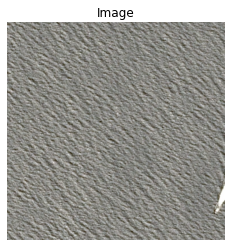

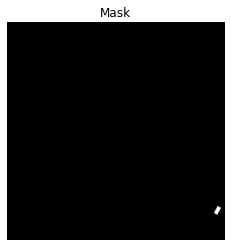

In [10]:
row = df.iloc[112]
image, mask = get_img_mask(df, row, train_images_dir, image_size)

# Display the image
plt.imshow(image.astype(np.uint8))
plt.axis('off')
plt.title('Image')
plt.show()

# Display the mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

In [11]:
def crop_image_and_mask(image, mask, crop_size):
    image = Image.fromarray(image.astype(np.uint8))
    mask = Image.fromarray(mask.astype(np.uint8))

    width, height = image.size
    crop_width, crop_height = crop_size

    cropped_images = []
    cropped_masks = []

    # Iterate over the image to create multiple crops
    for x in range(0, width, crop_width):
        for y in range(0, height, crop_height):
            # Calculate the crop coordinates
            left = x
            upper = y
            right = x + crop_width
            lower = y + crop_height

            # Crop the image
            cropped_image = image.crop((left, upper, right, lower))

            # Crop the mask with the same coordinates
            cropped_mask = mask.crop((left, upper, right, lower))

            # Append the cropped image and mask to the lists
            cropped_images.append(np.array(cropped_image))
            cropped_masks.append(np.array(cropped_mask))

    return cropped_images, cropped_masks


In [12]:
# Visualising crop

""" image, mask = get_img_mask(df.iloc[112], row, train_images_dir, image_size)

# Call the `crop_image_and_mask` function
cropped_images, cropped_masks = crop_image_and_mask(image, mask, crop_size)

# Visualize the cropped images and masks
num_crops = len(cropped_images)

fig, axs = plt.subplots(num_crops, 2, figsize=(8, num_crops*4))

for i in range(num_crops):
    axs[i, 0].imshow(cropped_images[i])
    axs[i, 0].set_title(f"Cropped Image {i+1}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(cropped_masks[i])
    axs[i, 1].set_title(f"Cropped Mask {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show() """


' image, mask = get_img_mask(df.iloc[112], row, train_images_dir, image_size)\n\n# Call the `crop_image_and_mask` function\ncropped_images, cropped_masks = crop_image_and_mask(image, mask, crop_size)\n\n# Visualize the cropped images and masks\nnum_crops = len(cropped_images)\n\nfig, axs = plt.subplots(num_crops, 2, figsize=(8, num_crops*4))\n\nfor i in range(num_crops):\n    axs[i, 0].imshow(cropped_images[i])\n    axs[i, 0].set_title(f"Cropped Image {i+1}")\n    axs[i, 0].axis(\'off\')\n    \n    axs[i, 1].imshow(cropped_masks[i])\n    axs[i, 1].set_title(f"Cropped Mask {i+1}")\n    axs[i, 1].axis(\'off\')\n\nplt.tight_layout()\nplt.show() '

In [13]:
def find_best(cropped_images, cropped_masks):
    max_area_index = max(range(len(cropped_masks)), key=lambda i: sum(sum(row) for row in cropped_masks[i]))
    return cropped_images[max_area_index], cropped_masks [max_area_index]

In [14]:
# Prepare data generator

class DataGenerator:
    def __init__(self, df, batch_size, image_size):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.datagen = ImageDataGenerator(rescale=1.0/255.0)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def generate(self):
        while True:
            batch_indices = np.random.choice(len(self.df), size=self.batch_size, replace=False)
            batch_df = self.df.iloc[batch_indices]
            images = []
            masks = []
            for _, row in batch_df.iterrows():
                image, mask = get_img_mask(batch_df, row, train_images_dir, self.image_size)
                cropped_images, cropped_masks = crop_image_and_mask(image, mask, crop_size)
                best_image, best_mask = find_best(cropped_images, cropped_masks)
                images.append(best_image)
                masks.append(best_mask.astype(float))

            images = np.array(images)
            masks = np.array(masks)

            # Apply data augmentation using ImageDataGenerator
            images = self.datagen.flow(images, shuffle=False).next()

            yield images, masks

In [15]:
def dice_score(pred_masks, true_masks, smooth=1e-7):
    intersection = K.sum(pred_masks * true_masks)
    union = K.sum(pred_masks) + K.sum(true_masks)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice


def bce_dice_loss(y_pred, y_target):
    # dice loss metric
    return (1-dice_score(y_pred, y_target))

In [16]:
# Compile the model

model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=bce_dice_loss, metrics=['binary_accuracy', dice_score])

In [17]:
# Create data generator
train_generator = DataGenerator(df_train_split, batch_size, image_size).generate()
val_generator = DataGenerator(df_val_split, batch_size, image_size).generate()

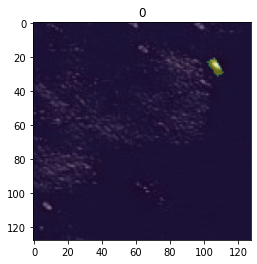

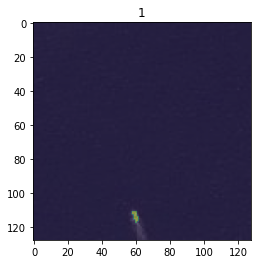

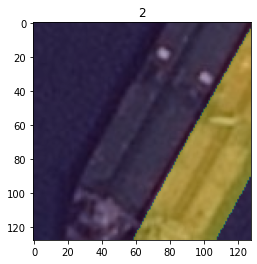

In [18]:
images, masks = next(train_generator)

for i in range(0, (len(images))-13):
    plt.imshow(images[i])
    plt.imshow(masks[i], alpha=0.4)
    plt.title(i)

    plt.show()

In [19]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=len(df_train_split) // batch_size,
                    validation_data=val_generator,
                    validation_steps=len(df_val_split) // batch_size,
                    callbacks=callbacks_list,
                    verbose=1)
model.save("./full_model")

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.7588 - binary_accuracy: 0.6262 - dice_score: 0.2412
Epoch 1: val_loss improved from inf to 0.63801, saving model to .\best_model


INFO:tensorflow:Assets written to: .\best_model\assets


INFO:tensorflow:Assets written to: .\best_model\assets


62/62 [==============================] - 112s 2s/step - loss: 0.7588 - binary_accuracy: 0.6262 - dice_score: 0.2412 - val_loss: 0.6380 - val_binary_accuracy: 0.8434 - val_dice_score: 0.3620 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.6627 - binary_accuracy: 0.8231 - dice_score: 0.3373
Epoch 2: val_loss improved from 0.63801 to 0.57556, saving model to .\best_model


INFO:tensorflow:Assets written to: .\best_model\assets


INFO:tensorflow:Assets written to: .\best_model\assets


62/62 [==============================] - 101s 2s/step - loss: 0.6627 - binary_accuracy: 0.8231 - dice_score: 0.3373 - val_loss: 0.5756 - val_binary_accuracy: 0.8679 - val_dice_score: 0.4244 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.7522 - binary_accuracy: 0.5195 - dice_score: 0.2478
Epoch 3: val_loss did not improve from 0.57556

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
62/62 [==============================] - 101s 2s/step - loss: 0.7522 - binary_accuracy: 0.5195 - dice_score: 0.2478 - val_loss: 0.6951 - val_binary_accuracy: 0.6239 - val_dice_score: 0.3049 - lr: 0.0010
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 0.7101 - binary_accuracy: 0.6875 - dice_score: 0.2899
Epoch 4: val_loss did not improve from 0.57556

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
62/62 [==============================] - 100s 2s/step - loss: 0.7101 - binary_accuracy: 0.6875 - dic

INFO:tensorflow:Assets written to: .\best_model\assets


INFO:tensorflow:Assets written to: .\best_model\assets


62/62 [==============================] - 99s 2s/step - loss: 0.5856 - binary_accuracy: 0.8430 - dice_score: 0.4144 - val_loss: 0.5707 - val_binary_accuracy: 0.8156 - val_dice_score: 0.4293 - lr: 1.0000e-05
Epoch 6/10
62/62 [==============================] - ETA: 0s - loss: 0.6202 - binary_accuracy: 0.8179 - dice_score: 0.3798
Epoch 6: val_loss did not improve from 0.57068

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
62/62 [==============================] - 96s 2s/step - loss: 0.6202 - binary_accuracy: 0.8179 - dice_score: 0.3798 - val_loss: 0.6257 - val_binary_accuracy: 0.7835 - val_dice_score: 0.3743 - lr: 1.0000e-05
Epoch 7/10
62/62 [==============================] - ETA: 0s - loss: 0.5963 - binary_accuracy: 0.8100 - dice_score: 0.4037
Epoch 7: val_loss did not improve from 0.57068

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
62/62 [==============================] - 97s 2s/step - loss: 0.5963 - binary_accuracy: 0.8100 

INFO:tensorflow:Assets written to: ./full_model\assets


INFO:tensorflow:Assets written to: ./full_model\assets
